In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
from tqdm import tqdm
import emcee
import corner
import pymultinest
import json
import getdist
from getdist import plots, MCSamples

Create the 4-d u-function as mentioned:

In [2]:
def sigmoid(x, a, b, c, d):
    """
    Returns the sigmoid function f(x) = a/(1 + e^(-(bx - c))) + d 
    
    Parameters are:
    
    a adjusts the minimum and maximum asymptotes of the sigmoidal curve
    b adjusts the steepness of the sigmoidal curve
    c shifts the curve left and right
    d shifts the curve up and down
    
    """
    return a/(1 + np.exp(-(b * x - c))) + d

def neg_exponential(x, a, b, c, d):
    """
    Returns the negative exponential function f(x) = a * e^-bx + c
    
    Parameters are:
    
    a shifts the curve left and right
    b adjusts the steepness of the curve
    c is the horizontal asymptote
    d shifts the curve left and right
    
    """
    return a * np.exp(-b * (x + d)) + c
    

def get_3d_log_likelihood(omega_a, omega_d, m_a, 
                          a_a, b_a, c_a, d_a, 
                          a_d, b_d, c_d, d_d, 
                          a_sa, b_sa, c_sa, d_sa, 
                          a_sd, b_sd, c_sd, d_sd, 
                          a_theta, b_theta, c_theta, d_theta):
    """
    Gets the 3d log likelihood for either de or dm with the given parameters for the means in the 
    omega_a and omega_de/dm direction, the variance in the omega_a direction, and the parameters for the rotation by an angle theta
    """
    
    # x vector
    x = np.array([omega_a, omega_d])  # x = [omega_a, omega_de/dm] vector
    
    # means in the mu_a and mu_de direction
    # sigmoid curves mu_a(m_a) and mu_de(m_a)
    mu_a = sigmoid(m_a, a_a, b_a, c_a, d_a)  # mu_a = mu_a(m_a)
    mu_d = sigmoid(m_a, a_d, b_d, c_d, d_d)  # mu_d = mu_d(m_a) but the sigmoidal curve has different parameters
    # mu is a vector of the two
    mu = np.array([mu_a, mu_d])  # mu = [mu_a, mu_d] vector
    
    # covariance matrix C
    sigma_a = neg_exponential(m_a, a_sa, b_sa, c_sa, d_sa)  # variance in a direction: negative exponential curve, sigma_a = sigma_a(m_a)
    sigma_d = neg_exponential(m_a, a_sd, b_sd, c_sd, d_sd) # variance in de direction: sigmoid curve, sigma_de = sigma_de(m_a)
 
    # rotation
    theta = sigmoid(m_a, a_theta, b_theta, c_theta, d_theta)
    # covariance matrix
    C = np.array(([sigma_a, 0], 
                  [0, sigma_d]))
    # rotation matrix
    rot = np.array(([np.cos(theta), -np.sin(theta)], 
                    [np.sin(theta), np.cos(theta)]))
    
    # return 2d gaussian value, applying the appropriate rotation
    f = np.exp(-((x - mu).T @ np.linalg.inv(rot @ C @ rot.T) @ (x - mu)))  # general expression for a 2D Gaussian

    return f

def get_1d_gaussian(omega_d, m_a, 
                    a_d, b_d, c_d, d_d, 
                    a_sd, b_sd, c_sd, d_sd):
    """
    Gets the 1d gaussian of omega_de or omega_dm evaluated at a given m_a (to multiply with the 3d function)
    """
    # compute 1d gaussian 
    mu_d = sigmoid(m_a, a_d, b_d, c_d, d_d)  # compute mu_d and sigma_d except with the other (de/dm) parameters not used for the 3d likelihood
    sigma_d = neg_exponential(m_a, a_sd, b_sd, c_sd, d_sd)
    # general form of 1d gaussian for a given mu and sigma
    f = np.exp(-((omega_d - mu_d) ** 2)/sigma_d)
    
    return f

    
def log_likelihood(omega_a, omega_de, omega_dm, m_a, 
                   a_a_de=0., b_a_de=1.5, c_a_de=6., d_a_de=0., 
                   a_a_dm=0., b_a_dm=1.5, c_a_dm=6., d_a_dm=0.,
                   a_de=0., b_de=1.5, c_de=6., d_de=9.,
                   a_dm=0., b_dm=1.5, c_dm=6., d_dm=9.,
                   a_sa_de=10000., b_sa_de=2., c_sa_de=1.5, d_sa_de=0,
                   a_sa_dm=10000., b_sa_dm=-2, c_sa_dm=1.5, d_sa_dm=-20,
                   a_sde=0., b_sde=0., c_sde=0.2, d_sde=0, 
                   a_sdm=0., b_sdm=0., c_sdm=0.2, d_sdm=0, 
                   a_theta_de=np.pi/4, b_theta_de=1.5, c_theta_de=6., d_theta_de=-np.pi/4, 
                   a_theta_dm=-np.pi/4, b_theta_dm=1.5, c_theta_dm=24., d_theta_dm=0.):

    # omega_a, omega_de, omega_dm, m_a = params  # x is omega_a, y is omega_de, z is omega_dm, w is m_a
    
    # low m_a means that omega_a varies with omega_de and constant with omega_dm
    # this is DE dominates
    if m_a < 10:
        # compute the 3d log likelihood in the omega_a - omega_de plane, using the given parameters
        f_3d = get_3d_log_likelihood(omega_a, omega_de, m_a, 
                                  a_a_de, b_a_de, c_a_de, d_a_de, 
                                  a_de, b_de, c_de, d_de, 
                                  a_sa_de, b_sa_de, c_sa_de, d_sa_de, 
                                  a_sde, b_sde, c_sde, d_sde, 
                                  a_theta_de, b_theta_de, c_theta_de, d_theta_de)
        # compute the 1d gaussian in the omega_a - omega_dm plane, using those parameters
        f_1d = get_1d_gaussian(omega_dm, m_a, 
                               a_dm, b_dm, c_dm, d_dm, 
                               a_sdm, b_sdm, c_sdm, d_sdm)
        
    # high m_a means that omega_a constant with omega_de and varies with omega_dm
    # this is DM dominates
    elif m_a >= 10:
        # compute the 3d log likelihood in the omega_a - omega_dm plane, using the given parameters 
        f_3d = get_3d_log_likelihood(omega_a, omega_dm, m_a, 
                                  a_a_dm, b_a_dm, c_a_dm, d_a_dm, 
                                  a_dm, b_dm, c_dm, d_dm, 
                                  a_sa_dm, b_sa_dm, c_sa_dm, d_sa_dm, 
                                  a_sdm, b_sdm, c_sdm, d_sdm, 
                                  a_theta_dm, b_theta_dm, c_theta_dm, d_theta_dm)
        # compute the 1d gaussian in the omega_a - omega_de plane, using those parameters
        f_1d = get_1d_gaussian(omega_de, m_a, 
                               a_de, b_de, c_de, d_de, a_sde, 
                               b_sde, c_sde, d_sde)
    
    # multiply the gaussian with our original 1d gaussian to get the full likelihood
    # compute the 1d gaussian in the omega_a - omega_de plane, using those param
    return f_3d * f_1d
    
#     f_3d = get_3d_log_likelihood(omega_a, omega_dm, m_a, 
#                           a_a_dm, b_a_dm, c_a_dm, d_a_dm, 
#                           a_dm, b_dm, c_dm, d_dm, 
#                           a_sa_dm, b_sa_dm, c_sa_dm, d_sa_dm, 
#                           a_sdm, b_sdm, c_sdm, d_sdm, 
#                           a_theta_dm, b_theta_dm, c_theta_dm, d_theta_dm)
#     # compute the 1d gaussian in the omega_a - omega_de plane, using those param
#     return f_3d # * f_1d


Plot all the curves to make sure the function behaviour is working as intended:

In [3]:
# MEANS
# means in the a axis for the DE and DM functions
a_a_de, b_a_de, c_a_de, d_a_de = 0., 1.5, 6., 0. 
a_a_dm, b_a_dm, c_a_dm, d_a_dm = 0., 1.5, 6., 0.
# means in the de/dm axes for the DE and DM functions
a_de, b_de, c_de, d_de = 0., 1.5, 6., 9. 
a_dm, b_dm, c_dm, d_dm = 0., 1.5, 6., 9.

# VARIANCES
# variances in the a axis for the DE and DM functions
a_sa_de, b_sa_de, c_sa_de, d_sa_de = 10000., 2., 1.5, 0.
a_sa_dm, b_sa_dm, c_sa_dm, d_sa_dm = 10000., -2., 1.5, -20.
# variances in the de/dm axes for the DE and DM functions
a_sde, b_sde, c_sde, d_sde = 0., 0., 0.2, 0.
a_sdm, b_sdm, c_sdm, d_sdm = 0., 0., 0.2, 0.

# ROTATIONS
# rotation angles in the a-de and a-dm planes for the DE and DM functions
a_theta_de, b_theta_de, c_theta_de, d_theta_de = np.pi/4, 1.5, 6., -np.pi/4
a_theta_dm, b_theta_dm, c_theta_dm, d_theta_dm = -np.pi/4, 1.5, 24., 0.

Plot how the means `mu_a`, `mu_de` and `mu_dm` for the $3$-D DE and DM functions evolve with $m_a$, respectively:

They should appear constant at $\mu_a = 0$ and $\mu_{DE} = \mu_{DM} = 9$.

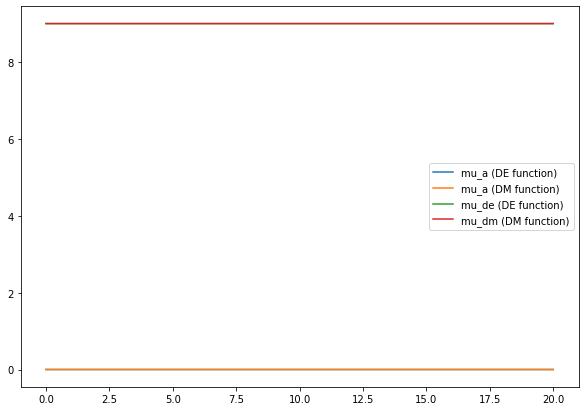

In [4]:
%matplotlib inline
# generate test mas
test_mas = np.linspace(0, 20, int(1e4))
# plot
plt.figure(figsize = (10, 7))
# mu_a for the DE and DM functions
plt.plot(test_mas, sigmoid(test_mas, a_a_de, b_a_de, c_a_de, d_a_de), alpha=1, label = 'mu_a (DE function)')
plt.plot(test_mas, sigmoid(test_mas, a_a_de, b_a_de, c_a_de, d_a_de), alpha=1, label = 'mu_a (DM function)')
# mu_de/mu-dm for the DE and DM functions
plt.plot(test_mas, sigmoid(test_mas, a_de, b_de, c_de, d_de), alpha = 1, label = 'mu_de (DE function)')
plt.plot(test_mas, sigmoid(test_mas, a_dm, b_dm, c_dm, d_dm), alpha = 1, label = 'mu_dm (DM function)')
# legend
plt.legend()

Plot how the variances `sigma_a`, `sigma_de` and `sigma_dm` for the $3$-D DE and DM functions evolve with $m_a$, respectively:

They should shrink (for the DE plot) or grow (for the DM plot) exponentially along the $a$-axis and be constant along the DE/DM axis.

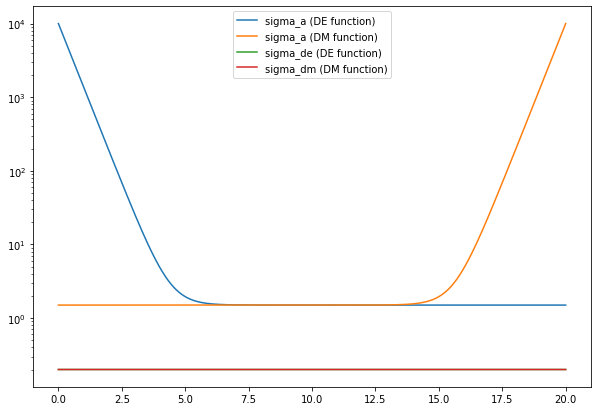

In [5]:
# plot
plt.figure(figsize = (10, 7))
# sigma_a for the DE and DM functions
plt.plot(test_mas, neg_exponential(test_mas, a_sa_de, b_sa_de, c_sa_de, d_sa_de), alpha=1, label = 'sigma_a (DE function)')
plt.plot(test_mas, neg_exponential(test_mas, a_sa_dm, b_sa_dm, c_sa_dm, d_sa_dm), alpha=1, label = 'sigma_a (DM function)')
# sigma_de/sigma_dm for the DE and DM functions
plt.plot(test_mas, neg_exponential(test_mas, a_sde, b_sde, c_sde, d_sde), alpha = 1, label = 'sigma_de (DE function)')
plt.plot(test_mas, neg_exponential(test_mas, a_sdm, b_sdm, c_sdm, d_sdm), alpha = 1, label = 'sigma_dm (DM function)')
# legend
plt.yscale('log')
plt.legend()

Plot how the rotation angles `theta_de` and `theta_dm` for the $3$-D DE and DM functions evolve with $m_a$, respectively:

For the DE plot, it should sigmoidally go from -$\frac{\pi}{4}$ to $0$ for $0 < m_a < 10$ and be constant at $0$ for $10 < m_a < 20$.

For the DM plot, it should be constant at $0$ for $0 < m_a < 10$ and sigmoidally go from $0$ to -$\frac{\pi}{4}$ for $10 < m_a < 20$.

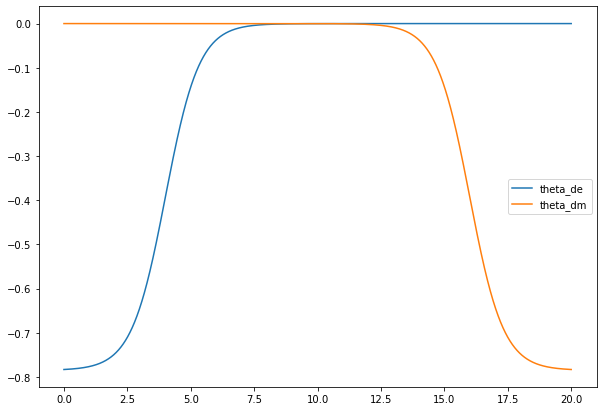

In [6]:
# plot
plt.figure(figsize = (10, 7))
# theta_de
plt.plot(test_mas, sigmoid(test_mas, a_theta_de, b_theta_de, c_theta_de, d_theta_de), alpha=1, label = 'theta_de')
# theta_dm
plt.plot(test_mas, sigmoid(test_mas, a_theta_dm, b_theta_dm, c_theta_dm, d_theta_dm), alpha=1, label = 'theta_dm')
# legend
plt.legend()

Compute the function over some $4$-D hypercube:

In [11]:
from multiprocessing import Pool

npoints = 20

# bounds of our sampling
x_lower, x_upper = 0, 10  # omega_a
y_lower, y_upper = 0, 10  # omega_de
z_lower, z_upper = 0, 10  # omega_dm
w_lower, w_upper = 0, 20  # m_a

X, Y, Z, W = np.meshgrid(np.linspace(x_lower, x_upper, npoints), np.linspace(y_lower, y_upper, npoints), 
                      np.linspace(z_lower, z_upper, npoints), np.linspace(w_lower, w_upper, npoints))


likelihood_arr = np.zeros((npoints, npoints, npoints, npoints))

for i in tqdm(range(0, len(X))):
    for j in range(0, len(Y)):
        for k in range(0, len(Z)):
            for l in range(0, len(W)):
                likelihood_arr[i, j, k, l] = log_likelihood(X[i, j, k, l], Y[i, j, k, l], Z[i, j, k, l], W[i, j, k, l])

# mutliprocessing!
                
# # multiprocessing to speed this up:
# with Pool() as pool:
#     testarr = pool.starmap(log_likelihood, tqdm([(X[i, j, k, l], Y[i, j, k, l], Z[i, j, k, l], W[i, j, k, l])
#                                                  for i in range(0, len(X)) 
#                                                  for j in range(0, len(Y)) 
#                                                  for k in range(0, len(Z)) 
#                                                  for l in range(0, len(W))]))

# # make testarr into an array with the proper shape
# testarr = np.array(testarr).reshape(npoints, npoints, npoints, npoints)

100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


In [20]:
X, Y, Z, W

(array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          ...,
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ]],
 
         [[ 0.52631579,  0.52631579,  0.52631579, ...,  0.52631579,
            0.52631579,  0.52631579],
          [ 0.52631579,  0.52631579,  0.52631579, ...,  0.52631579,
            0.52631579,  0.52631579],
          [ 0.52631579,  0.52631579,  0.52631579, ...,  0.52631579,
            0.52631579,  0.52631579],
          ...,
          [ 0

In [12]:
likelihood_arr = likelihood_arr.swapaxes(0, 1)  # swaps the x and y axes in the likelihood array

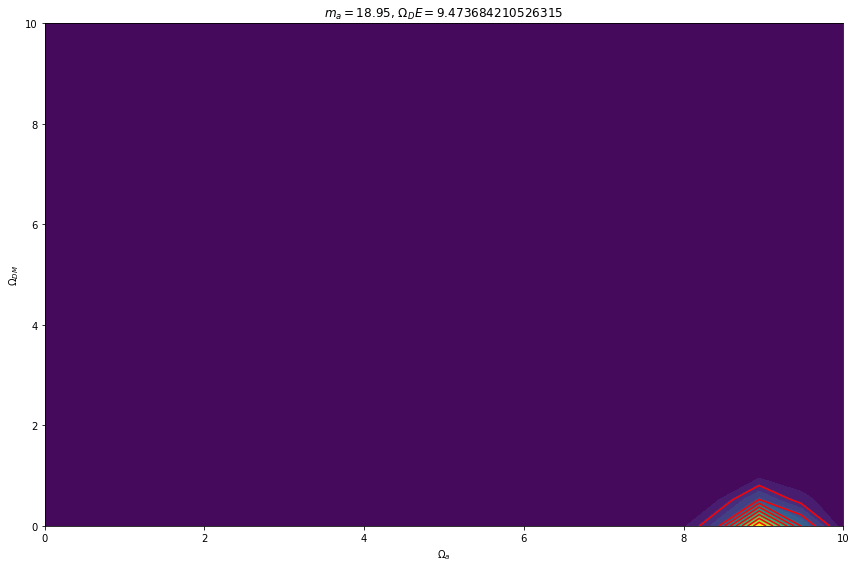

In [8]:
ws = np.linspace(w_lower, w_upper, npoints)
ys = np.linspace(y_lower, y_upper, npoints)

omega_de = 18
w_ind = 18

plt.figure(figsize = (12, 8))
arr = likelihood_arr[:, omega_de, :, w_ind]

contour_min = np.min(arr)
contour_max = np.max(arr)

# plot
plt.contourf(X[0, :, 0, :], Z[:, 0, :, 0], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
plt.contour(X[0, :, 0, :], Z[:, 0, :, 0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
# plt.clabel(ax2, inline=True, fontsize=10)
plt.xlabel(r'$\Omega_{a}$')
plt.ylabel(r'$\Omega_{DM}$') # x is omega_a, y is omega_de, z is m_a
plt.title(fr'$m_a = ${np.round(ws[w_ind], 2)}, $\Omega_DE = ${ys[omega_de]}') # x is omega_a, y is omega_de, z is m_a
plt.tight_layout()

Test to make sure that meshgrid and multiprocessing are doing what I think they are:

In [9]:
testX, testY, testZ, testW = np.meshgrid(range(0, 4), range(0, 4), range(0, 4), range(0, 4))

def g(x):
    return x

with Pool() as pool:
    test2 = pool.map(g, [f'{i}, {j}, {k}, {l}' 
                  for i in np.linspace(0, 4, 4) 
                  for j in np.linspace(0, 8, 4) 
                  for k in np.linspace(0, 12, 4) 
                  for l in np.linspace(0, 16, 4)])
    
test2 = np.array(test2).reshape(4, 4, 4, 4)

Plotting:

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


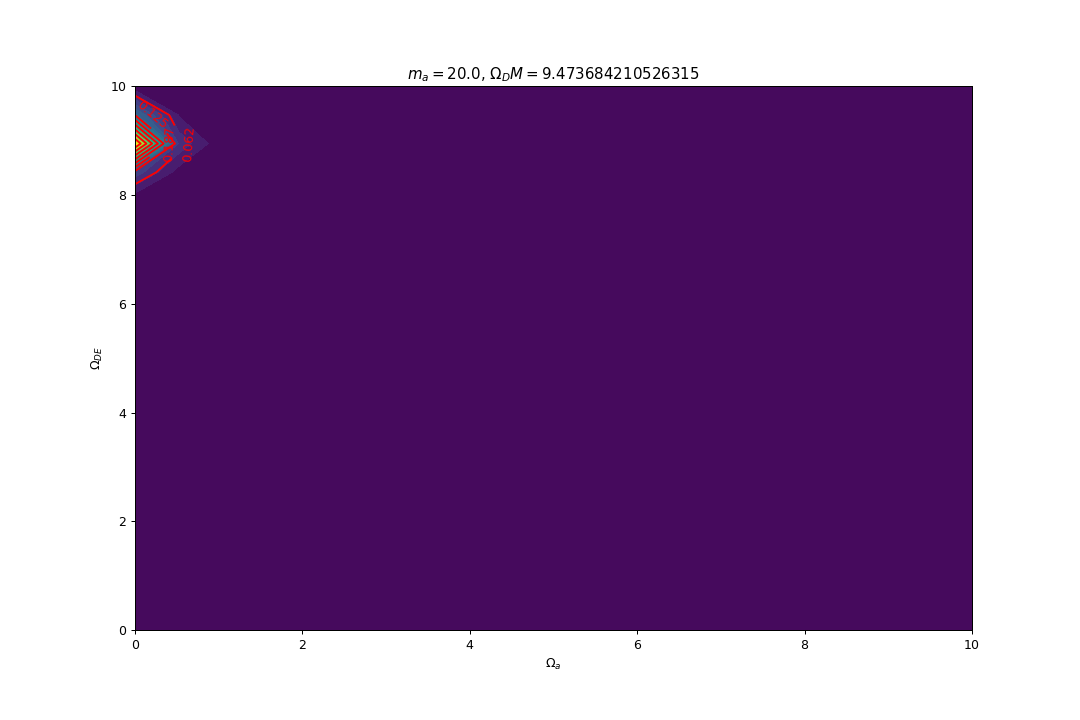

In [15]:
%matplotlib notebook
%matplotlib notebook

# plotting omega_a - omega_de (this one works)

import matplotlib.pyplot as plt  
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

# ws
ws = np.linspace(w_lower, w_upper, npoints)
# hold omega_dm constant, vary m_a
omega_dm = npoints * 9//10
# zs
zs = np.linspace(z_lower, z_upper, npoints)

fig, ax = plt.subplots(1, 1, figsize = (12, 8))

def animate(w_ind, omega_dm_ind=omega_dm):
    ax.clear()
    arr = likelihood_arr[:, :, omega_dm_ind, w_ind].T  # hold omega_dm constant
    # min and max for the contours
    contour_min = np.min(arr)
    contour_max = np.max(arr)
    
    # plot
    ax.contourf(X[:, :, 0, 0], Y[:, :, 0, 0], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
    ax2 = ax.contour(X[:, :, 0, 0], Y[:, :, 0, 0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    ax.clabel(ax2, inline=True, fontsize=10)
    ax.set_xlabel(r'$\Omega_{a}$'), ax.set_ylabel(r'$\Omega_{DE}$') # x is omega_a, y is omega_de, z is m_a
    ax.set_title(fr'$m_a = ${np.round(ws[w_ind], 2)}, $\Omega_DM = ${zs[omega_dm]}') # x is omega_a, y is omega_de, z is m_a
    
ani = FuncAnimation(fig, animate, frames=len(Z), interval=200, repeat=False)

# Save the animation as an animated GIF
ani.save("4d_u_function_plot_alternate.gif", dpi=500, writer=PillowWriter(fps=10))
# plt.close()

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


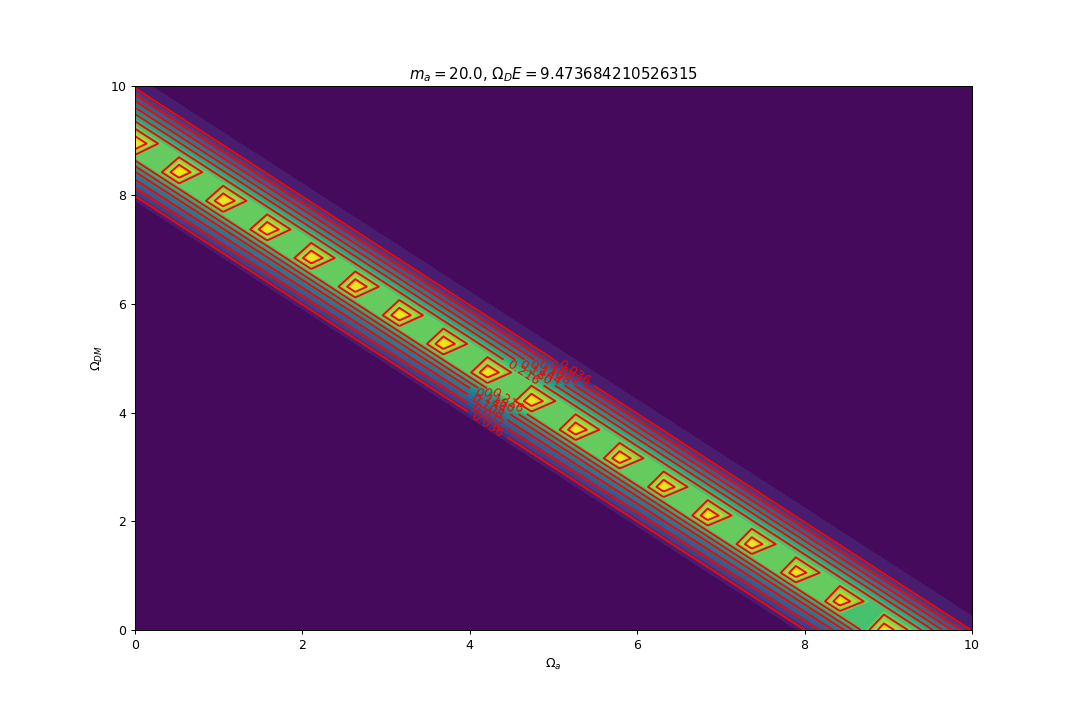

In [14]:
%matplotlib notebook
%matplotlib notebook

# plotting omega_a - omega_de (this should give the rotating contour but does not...)

from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

# zs
ws = np.linspace(w_lower, w_upper, npoints)
# hold omega_de constant, vary m_a
omega_de = npoints * 9//10
# ys (omega_de s)
ys = np.linspace(y_lower, y_upper, npoints)

fig, ax = plt.subplots(1, 1, figsize = (12, 8))

def animate(w_ind, omega_de_ind=omega_de):
    ax.clear()
    arr = likelihood_arr[:, omega_de_ind, :, w_ind].T  # need to transpose? idk why
    # min and max for the contours
    contour_min = np.min(arr)
    contour_max = np.max(arr)
    
    # plot
    ax.contourf(X[:, :, 0, 0], Y[:, :, 0, 0], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
    ax2 = ax.contour(X[:, :, 0, 0], Y[:, :, 0, 0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    ax.clabel(ax2, inline=True, fontsize=10)
    ax.set_xlabel(r'$\Omega_{a}$'), ax.set_ylabel(r'$\Omega_{DM}$') # x is omega_a, y is omega_de, z is m_a
    ax.set_title(fr'$m_a = ${np.round(ws[w_ind], 2)}, $\Omega_DE = ${ys[omega_de]}') # x is omega_a, y is omega_de, z is m_a

ani = FuncAnimation(fig, animate, frames=len(Z), interval=200, repeat=False)

# Save the animation as an animated GIF
ani.save("4d_u_function_plot_de_alternate.gif", dpi=500, writer=PillowWriter(fps=10))
# plt.close()

<IPython.core.display.Javascript object>


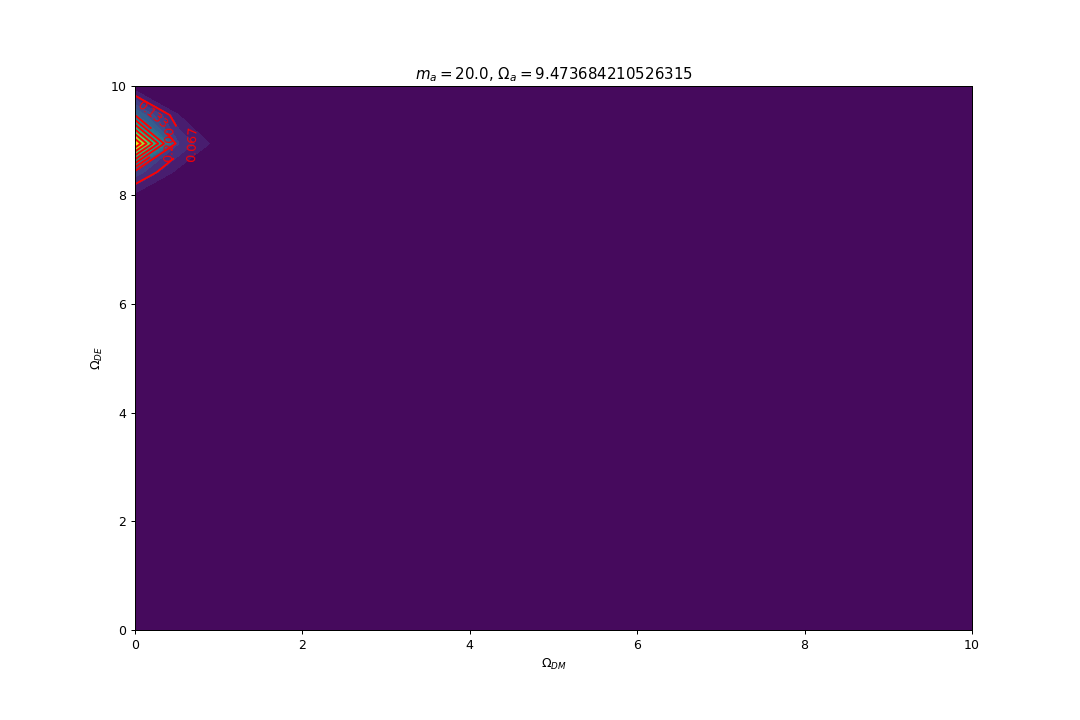

In [17]:
%matplotlib notebook
%matplotlib notebook

# plotting omega_de - omega_dm (this gives the rotating dm contour)

from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

# zs
ws = np.linspace(w_lower, w_upper, npoints)
# hold omega_a constant, vary m_a
omega_a = npoints * 9//10
# xs (omega_as)
xs = np.linspace(y_lower, y_upper, npoints)

fig, ax = plt.subplots(1, 1, figsize = (12, 8))

def animate(w_ind, omega_a_ind=omega_a):
    ax.clear()
    arr = likelihood_arr[omega_a_ind, :, :, w_ind]  # this needs to be transposed so the axes match up, why?
    # min and max for the contours
    contour_min = np.min(arr)
    contour_max = np.max(arr)
    
    # plot
    ax.contourf(X[:, :, 0, 0], Y[:, :, 0, 0], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
    ax2 = ax.contour(X[:, :, 0, 0], Y[:, :, 0, 0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    ax.clabel(ax2, inline=True, fontsize=10)
    ax.set_xlabel(r'$\Omega_{DM}$'), ax.set_ylabel(r'$\Omega_{DE}$') # x is omega_a, y is omega_de, z is m_a
    ax.set_title(fr'$m_a = ${np.round(ws[w_ind], 2)}, $\Omega_a = ${xs[omega_a]}') # x is omega_a, y is omega_de, z is m_a

ani = FuncAnimation(fig, animate, frames=len(Z), interval=200, repeat=False)

# Save the animation as an animated GIF
ani.save("4d_u_function_plot_de_dm_alternate.gif", dpi=500, writer=PillowWriter(fps=10))
# plt.close()

Now integrate over $\Omega_{DE}$ from $0$ to $10$ ($-\infty$ to $\infty$ should be the same...) and then $\Omega_{DM}$ from $0$ to $10$:

In [18]:
import scipy
# x is omega_a, y is omega_de, z is omega_dm, w is m_a

# multiprocessing to speed this up:

def f(omega_de, omega_dm, omega_a, m_a):
    return log_likelihood(omega_a, omega_de, omega_dm, m_a)

with Pool() as pool:
    integrated_likelihood = pool.starmap(scipy.integrate.dblquad, tqdm([(f, 0, 10, 0, 10, [X[0, i, 0, j], W[i, 0, 0, j]]) 
                                                                   for i in range(0, len(X)) 
                                                                   for j in range(0, len(W))]))
    
# make integrated likelihood into an array with the proper shape
integrated_likelihood = np.array(integrated_likelihood)[:,0].reshape(npoints, npoints)

100%|██████████| 400/400 [00:04<00:00, 88.93it/s]  


And plot it to see if it matches the u-plot:

<IPython.core.display.Javascript object>


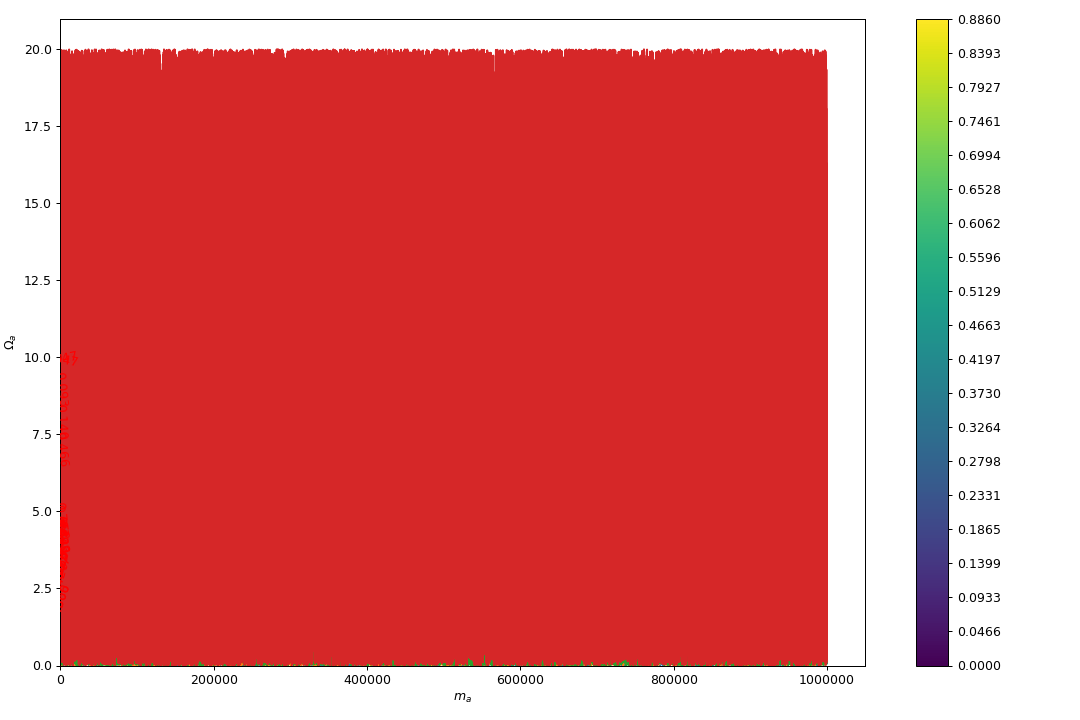

In [19]:
n_contour_points = 500  # number of poitns to use for the contour plot

# min and max for the contours
contour_min = np.min(integrated_likelihood)
contour_max = np.max(integrated_likelihood)

integrated_omega_a, integrated_m_a = X[:, :, 0, 0].T, Y[:, :, 0, 0].T # need to do this transposition otherwise the axes are flipped? not sure what the physical meaning of this is

# plot
plt.figure(figsize = (12, 8))
plt.contourf(integrated_m_a, integrated_omega_a, integrated_likelihood, levels=np.linspace(contour_min, contour_max, n_contour_points), cmap='viridis')
cb = plt.colorbar()
# cb.formatter = LogFormatterExponent(base=10)
# this goes from ~ -50 to 0
cb.set_ticks(np.linspace(contour_min, contour_max, 20), update_ticks=True)

plt.xlabel(r'$m_a$'), plt.ylabel(r'$\Omega_a$')

# CONTOURS
fig = plt.contour(integrated_m_a, integrated_omega_a, integrated_likelihood, levels=np.linspace(contour_min, contour_max, 20), colors='r')
plt.clabel(fig, inline=True, fontsize=10)
plt.tight_layout()

# save
# plt.savefig('integrated_4d_u_function.png', fmt='png')

## MCMC:

In [1]:
import h5py
import emcee
import matplotlib.pyplot as plt

In [2]:
burnin=200

filename='4d_u_function_mcmc_chains.h5'
reader = emcee.backends.HDFBackend(filename)
samples = reader.get_chain(discard=burnin)
log_prob_samples = reader.get_log_prob(discard=burnin)

In [ ]:
emcee.EnsembleSampler()

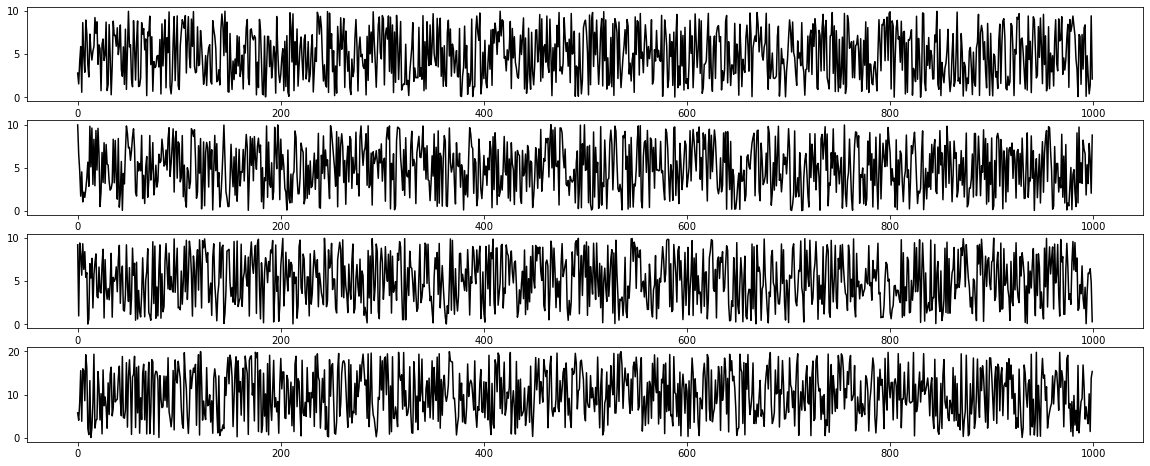

In [8]:
fig, ax = plt.subplots(4, 1, figsize = (20, 8))

for i in range(0, 4):
    ax[i].plot(samples[::1000, 0, i], 'k')

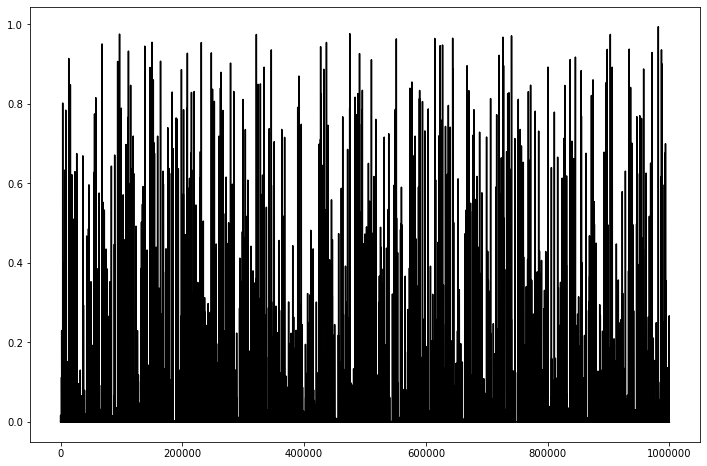

In [17]:
plt.figure(figsize = (12, 8))
plt.plot(log_prob_samples[:, 0], 'k')